**Import Packages**

In [1]:
!pip install torch torchvision torchaudio torcheval
!pip install pillow wandb
!pip install cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils cjm_pandas_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00


In [3]:
!pip install -U "ray[tune]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.5 MB/s eta 0:00:00


In [4]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy
from glob import glob

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
#from torcheval.tools import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import miniai dependencies
import fastcore.all as fc
'''
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook, ActivationStats
from miniai.accel import MixedPrecision, AccelerateCB
from miniai.init import BatchTransformCB, GeneralRelu, init_weights, set_seed, conv
from miniai.sgd import BatchSchedCB
from miniai.resnet import ResBlock
'''
# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, tensor_stats_df, get_torch_device, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas

In [5]:
import ray
from ray import tune
from ray import train

In [6]:
username = "jwang1031"
key = "e984afe21a1f3299c262cdea0a817209"
save_kaggle_creds(username, key, overwrite=False)

**Data Retrival from Kaggle**

In [7]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


In [8]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


In [9]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

100%|██████████| 3.55G/3.55G [00:34<00:00, 110MB/s] 


*Note: 19 classes in total*

In [10]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,two_up
1,three2
2,two_up_inverted
3,four
4,one
5,call
6,peace
7,stop
8,peace_inverted
9,no_gesture


In [11]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

**Display Sample Image**

Class: two_up


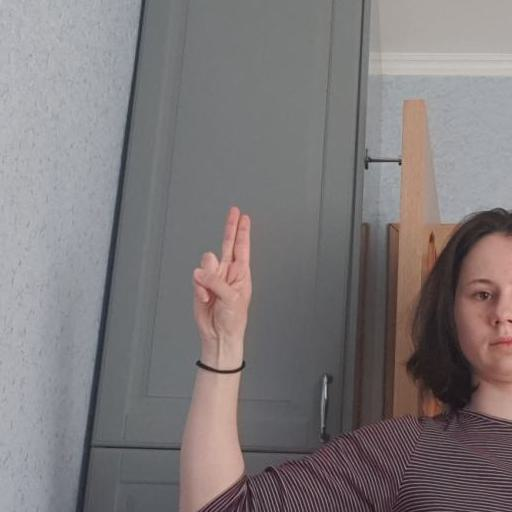

In [12]:
# Select a random image path from the list of image paths
img_path = random.choice(img_paths)

# Print the name of the class of the image, which is the name of the parent folder
print(f"Class: {img_path.parent.name}")

# Open the image using the path
sample_img = Image.open(img_path)

# Display the image
sample_img

**Data Transformation**

In [13]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [14]:
# ensure the image transforming into appropriate size for model
train_sz = (288,288)

In [15]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
len(train_paths), len(val_paths)

(138361, 15374)

In [16]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        """
        A PyTorch module that resizes an image tensor and adds padding to make it a square tensor.

        Args:
        max_sz (int, optional): The size of the square tensor.
        padding_mode (str, optional): The padding mode used when adding padding to the tensor.
        """
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode

    def forward(self, x):
        # Get the width and height of the image tensor
        w, h = TF.get_image_size(x)

        # Resize the image tensor so that its minimum dimension is equal to `max_sz`
        size = int(min(w, h) / (max(w, h) / self.max_sz))
        x = TF.resize(x, size=size)

        # Add padding to make the image tensor a square
        w, h = TF.get_image_size(x)
        offset = (self.max_sz - min(w, h)) // 2
        padding = [0, offset] if h < w else [offset, 0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz] * 2)

        return x

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 288, 288])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


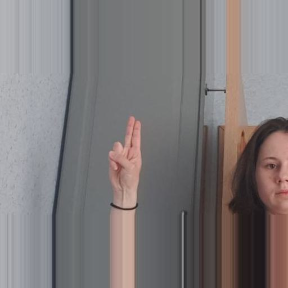

In [17]:
# sample image
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizePad` object
resize_pad = ResizePad(max_sz=max(train_sz))

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Apply random pixel copy to the resized and padded tensor
tensor_to_pil(resized_tensor)

In [18]:
train_tfms = [
    ResizePad(max_sz=max(train_sz)),
#     transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
#     rand_square_copy_tf,
#     rand_pixel_copy_tf,
#     rand_square_pixel_copy_tf
]
valid_tfms = [
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
]

In [19]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, classes, tfms):
        # Store the arguments as instance variables
        self.img_paths = img_paths
        self.classes = classes
        self.tfms = tfms

        # Create a mapping from class names to class indices
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get the path of the image at the given index
        img_path = self.img_paths[index]

        # Get the label of the image
        label = self.class_to_idx[img_path.parent.name]

        # Open the image
        image = Image.open(img_path).convert('RGB')

        return self.tfms(image), label

In [20]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths,
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths,
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(138361, 15374)

In [21]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths,
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths,
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(138361, 15374)

In [22]:
from torch.utils.data import Subset
subset_indices = torch.randperm(len(train_dataset))[:30000]
subset_train_dataset = Subset(train_dataset, subset_indices)

subset_indices = torch.randperm(len(valid_dataset))[:5000]
subset_valid_dataset = Subset(valid_dataset, subset_indices)

In [23]:
bs = 64 # batch size
train_dataloader = DataLoader(subset_train_dataset,
                              batch_size=bs,
                              shuffle=True,
                              num_workers=multiprocessing.cpu_count())

valid_dataloader = DataLoader(subset_valid_dataset, batch_size=bs)


# Print the number of batches in the training and validation dataloaders
len(train_dataloader), len(valid_dataloader)

(469, 79)

**Baseline Model - ResNext50**

In [24]:
from ray import train

In [27]:
num_classes = 19
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=models.resnet50(num_classes=num_classes).to(device)

In [28]:
def train1(model, optimizer, train_loader, device=None):
  criterion = nn.CrossEntropyLoss()
  device = device or torch.device("cpu")
  model.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()


In [29]:
def test(model, data_loader, device=None):
    all_predictions = []
    all_labels = []
    device = device or torch.device("cpu")
    model.eval()
    with torch.no_grad():
      for inputs, labels in valid_dataloader:
        # Move data to device if using GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append predictions and labels to the lists
        all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, or any other metric as needed
    accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
    return accuracy

In [30]:
torch.cuda.empty_cache()

**Saving Model**

In [31]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

# Assuming `train_dataset` is your training dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_classes = 19
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet50(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
tb_writer = SummaryWriter()

# def train_one_epoch(epoch_index, tb_writer):
#     running_loss = 0.0
#     last_loss = 0.0

#     model.train()
#     for i, data in enumerate(train_dataloader):
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 100 == 99:  # Log every 100 batches
#             last_loss = running_loss / 100  # Average loss per batch
#             print('  batch {} loss: {:.4f}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(train_dataloader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0.0

#     # Step the scheduler
#     scheduler.step()

#     return last_loss

# # Example usage
# for epoch in range(10):  # Number of epochs
#     loss = train_one_epoch(epoch, tb_writer)
#     print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
def train_one_epoch(epoch_index, tb_writer):
  #device = device or torch.device("cpu")
  running_loss = 0.
  last_loss = 0.
  i=0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting


  model.train()
  for i, data in enumerate(train_dataloader):
  #for images, labels in train_dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

        # Gather data and report
    running_loss += loss.item()
    if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
  scheduler.step()
  return last_loss

In [32]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.
# train_loss_history
train_loss_hist = []
# validation_loss_history
val_loss_hist = []

for epoch in range(EPOCHS):
    all_predictions = []
    all_labels = []
    loss_history_epoch = []
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(valid_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            all_predictions.extend(torch.argmax(voutputs, dim=1).cpu().numpy())
            all_labels.extend(vlabels.cpu().numpy())


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
    print('test accuracy: ',accuracy)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    train_loss_hist.append(avg_loss)
    val_loss_hist.append(avg_vloss)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 0.36398892855644227
  batch 200 loss: 0.2961113839149475
  batch 300 loss: 0.2795454432964325
  batch 400 loss: 0.2767498607635498
  batch 500 loss: 0.27612963104248045
  batch 600 loss: 0.2740816717147827
  batch 700 loss: 0.27197014808654785
  batch 800 loss: 0.27073805952072144
  batch 900 loss: 0.27083135867118835
  batch 1000 loss: 0.2697681500911713
  batch 1100 loss: 0.2670258219242096
  batch 1200 loss: 0.260121440410614
  batch 1300 loss: 0.2596151511669159
  batch 1400 loss: 0.25795677518844606
  batch 1500 loss: 0.2561220848560333
  batch 1600 loss: 0.25413358545303344
  batch 1700 loss: 0.24648110222816466
  batch 1800 loss: 0.24464143466949462
  batch 1900 loss: 0.23467382514476776
  batch 2000 loss: 0.2318133953809738
  batch 2100 loss: 0.22480240058898926
  batch 2200 loss: 0.2229905858039856
  batch 2300 loss: 0.21334845542907716
  batch 2400 loss: 0.20181460738182067
  batch 2500 loss: 0.19452921843528748
  batch 2600 loss: 0.1804276250600814

In [33]:
val_loss_hist_cpu = [tensor.cpu() for tensor in val_loss_hist]

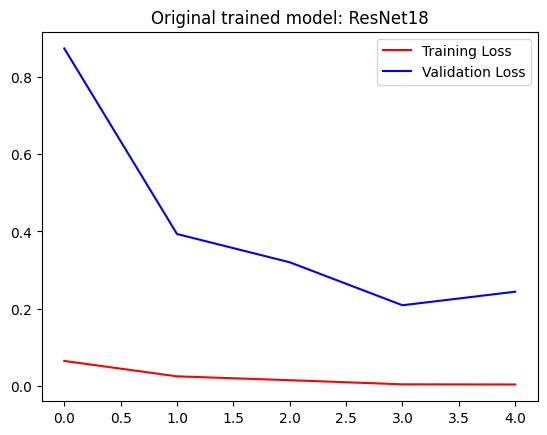

In [34]:
import matplotlib.pyplot as plt
plt.title('Original trained model: ResNet18')
plt.plot(train_loss_hist, 'r', label = 'Training Loss')
plt.plot(val_loss_hist_cpu, 'b', label = 'Validation Loss')
plt.legend()

In [35]:
torch.save(model.state_dict(), '/content/ResNet50.pth')

**Validating Model**

In [36]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Validating Subeset Data**

In [38]:
from torch.utils.data import Subset
subset_indices = torch.randperm(len(valid_dataset))[:5000]
subset_valid_dataset = Subset(valid_dataset, subset_indices)

In [39]:
valid_dataloader = DataLoader(subset_valid_dataset, batch_size=bs)
len(valid_dataloader)

79

In [40]:
model.eval()

all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        # Move data to device if using GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append predictions and labels to the lists
        all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, or any other metric as needed
accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.9706000089645386


In [41]:
valid_dataloader = DataLoader(valid_dataset, batch_size=bs)
len(valid_dataloader)

241

In [42]:
model.eval()

all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        # Move data to device if using GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append predictions and labels to the lists
        all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, or any other metric as needed
accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.9733966588973999


In [43]:
import torch

class_names = ["three", "four", "peace", "one", "peace_inverted", "stop", "call", "no_gesture", "three2", "mute", "ok", "two_up_inverted", "fist", "two_up", "like", "dislike", "palm", "rock", "stop_inverted"]

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)

# Create a mapping from label indices to class names
label_to_classname = {idx: name for idx, name in enumerate(class_names)}

# Initialize dictionaries to store correct predictions and total instances per class
correct_predictions = {classname: 0 for classname in class_names}
total_instances = {classname: 0 for classname in class_names}

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for label, prediction in zip(labels, predictions):
            class_name = label_to_classname[label.item()]
            if label == prediction:
                correct_predictions[class_name] += 1
            total_instances[class_name] += 1

# Calculate accuracy for each class
class_accuracies = {classname: correct / total for classname, correct, total in zip(class_names, correct_predictions.values(), total_instances.values()) if total > 0}

# Calculate overall accuracy
overall_accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()

print("Class Accuracies:", class_accuracies)
print("Overall Accuracy:", overall_accuracy)


Class Accuracies: {'three': 0.9878869448183042, 'four': 0.9772079772079773, 'peace': 0.9680555555555556, 'one': 0.9766536964980544, 'peace_inverted': 0.9743954480796586, 'stop': 0.9588068181818182, 'call': 0.9456681350954479, 'no_gesture': 0.9758522727272727, 'three2': 0.9829302987197724, 'mute': 0.9807407407407407, 'ok': 0.9773691654879774, 'two_up_inverted': 0.9474474474474475, 'fist': 0.978448275862069, 'two_up': 0.9737609329446064, 'like': 0.9703264094955489, 'dislike': 0.9733520336605891, 'palm': 0.9763313609467456, 'rock': 0.9684361549497847, 'stop_inverted': 0.9766483516483516}
Overall Accuracy: 0.9733966588973999


In [44]:
df_class_accuracies = pd.DataFrame(list(class_accuracies.items()), columns=['Class Name', 'Accuracy'])
df_class_accuracies

,Class Name,Accuracy
0,three,0.987887
1,four,0.977208
2,peace,0.968056
3,one,0.976654
4,peace_inverted,0.974395
5,stop,0.958807
6,call,0.945668
7,no_gesture,0.975852
8,three2,0.982930
9,mute,0.980741
